In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.085 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

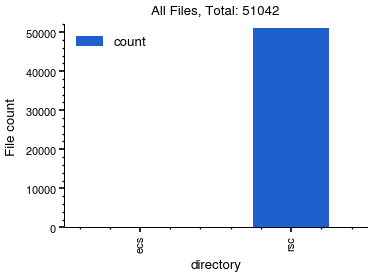

,directory,count
0,ecs,42
1,rsc,51000


In [7]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

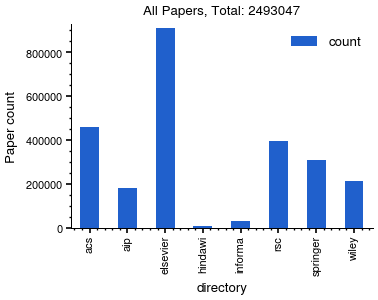

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa,27898
5,rsc,392346
6,springer,309847
7,wiley,213329


In [8]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

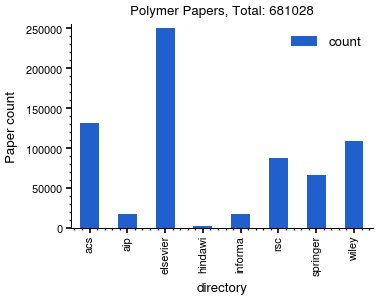

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa,17396
5,rsc,87429
6,springer,66532
7,wiley,108968


In [8]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

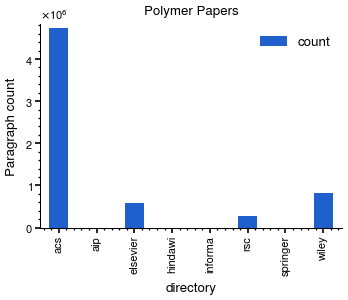

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,591008
3,hindawi,74
4,informa,24
5,rsc,281216
6,springer,74
7,wiley,826522


In [9]:
df = execute("""
             SELECT directory, count(*) FROM paper_texts pt
             -- only the polymer papers
             JOIN filtered_papers fp ON fp.doi = pt.doi 
             GROUP BY directory;
""")
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title="Polymer Papers")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

In [13]:
db.rollback()

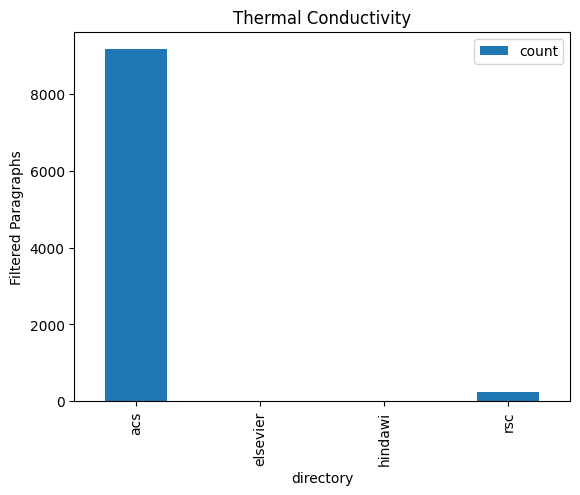

,directory,count
0,acs,9152
1,elsevier,1
2,hindawi,1
3,rsc,250


In [25]:
df = execute("""
    -- property specific heuristic filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'property_thermal_conductivity'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'Thermal Conductivity')
plt.savefig('notebooks/property_thermal_cond_hf_para_per_directory.png', dpi=600)
plt.show()
df

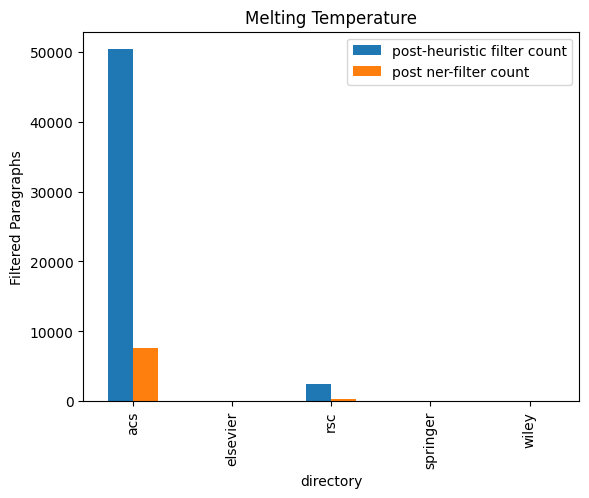

Merged Dataframe:
  directory  post-heuristic filter count  post ner-filter count
0       acs                        50366                   7657
1  elsevier                           19                     17
2       rsc                         2427                    366
3  springer                           10                     10
4     wiley                            9                      7


In [26]:

df_property = execute("""
    SELECT pt.directory, COUNT(*) AS property_count
    FROM filtered_paragraphs fp
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'property_tm'
    GROUP BY pt.directory;
""")

df_ner = execute("""
    SELECT pt.directory, COUNT(*) AS ner_count
    FROM filtered_paragraphs fp
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_tm'
    GROUP BY pt.directory;
""")
                 
# Merging the dataframes on the 'directory' column
df_merged = pd.merge(df_property, df_ner, on='directory', how='inner')
df_merged.rename(columns={'property_count': 'post-heuristic filter count', 'ner_count': 'post ner-filter count'}, inplace=True)


ax = df_merged.set_index('directory').plot.bar()
ax.set(ylabel='Filtered Paragraphs', title='Melting Temperature')


plt.savefig('notebooks/tm_property_vs_ner_para_per_directory.png', dpi=600)
plt.show()

print("Merged Dataframe:")
print(df_merged)

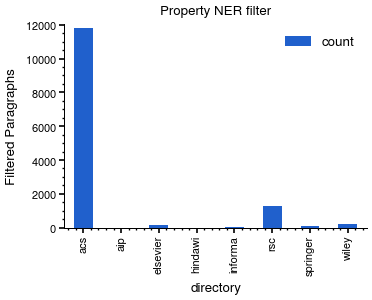

,directory,count
0,acs,11793
1,aip,2
2,elsevier,167
3,hindawi,2
4,informa,19
5,rsc,1275
6,springer,88
7,wiley,189


In [10]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_%'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'Property NER filter')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

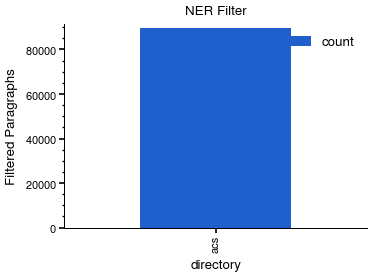

,directory,count
0,acs,89511


In [11]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'NER Filter')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [12]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,64129


In [13]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,138459


In [14]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [15]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [16]:
def plot_histogram(df, name, unit):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', label='Total: %d' %df.shape[0], ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name}.png', dpi=600)
    plt.show()

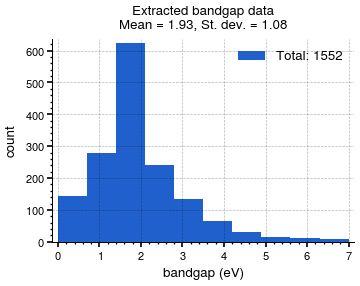

,doi,material,numeric_value,unit
0,10.1007/s10854-018-0226-3,polyvinyl alcohol,1.50,
1,10.1007/s10854-018-0226-3,2.5,1.50,
2,10.1007/s10854-018-0226-3,polyvinyl alcohol,2.80,eV
3,10.1007/s10854-018-0226-3,2.5,2.80,eV
4,10.1021/ma2020529,poly(thienylene vinylenes),1.65,eV
...,...,...,...,...
1547,10.1021/cm011553r,PM-PPV,1.94,eV
1548,10.1021/cm011553r,PM-PPV,1.94,eV
1549,10.1021/cm011553r,PM-PPV,1.96,eV
1550,10.1021/jacs.8b07560,MAPbBr_{3},2.20,eV


In [17]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap', 'eV')
df

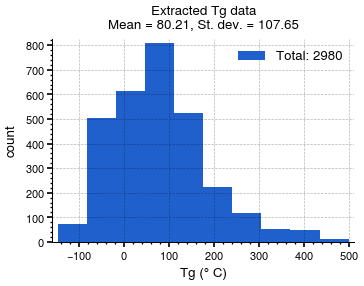

,doi,material,numeric_value,unit
0,10.1039/c6gc03238a,polylactic acid,50.0,° C
1,10.1039/c6gc03238a,polylactic acid,84.5,° C
2,10.1039/c6gc03238a,polycaprolactone,-60.0,° C
3,10.1039/c6gc03238a,polycaprolactone,28.5,° C
4,10.1039/c6gc03238a,polyethylene terephthalate,67.0,° C
...,...,...,...,...
2975,10.1021/acs.iecr.7b02846,polyethylene carbonate,-65.0,° C
2976,10.1021/acs.iecr.7b02846,LiFSI,17.0,° C
2977,10.1021/acs.iecr.7b02846,LiFSI,68.5,K( ° C)
2978,10.1021/acs.iecr.7b02846,LiFSI,74.5,K( ° C)


In [18]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg', '°C')
df

In [19]:
unit_counts(df)

unit
° C                   711
                       44
∼ ° C                  34
+ / ° C                23
° C   ° C               9
+ /                     7
+ / K                   5
° C ° C                 5
∼  ° C                  5
approximately  ° C      4
∼ K                     3
∼   ° C                 3
/ ° C                   2
J g^{-1}                2
,,,  ° C                2
,                       2
+/ ° C                  2
≃ K                     2
} J^{13}^{}^{}          1
° C + /                 1
∼  0 ° C                1
° C ≤                   1
° C(midpoint)           1
° C)containin           1
s                       1
∼  ∼ ° C                1
x                       1
delineated  ° C         1
nm^{3}                  1
negative  ° C           1
) °                     1
+ / J/(g K)             1
, ° C                   1
,,, ° C                 1
,,,,  ° C               1
./ ° C                  1
3 ° C                   1
:                       1
C/GPa  

In [19]:
df = execute("select * from property_metadata")
df.name

0     gravimetric energy density
1      gravimetric power density
2           specific capacitance
3                current density
4          areal current density
                 ...            
77                     luminance
78          luminance efficiency
79               dielectric loss
80         capacitance retention
81                  power factor
Name: name, Length: 82, dtype: object

In [20]:
postgres.disconnect()